In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pymongo import MongoClient

In [2]:
mongo_uri = "mongodb://hadoop-vm.internal.cloudapp.net:27017/ca2"

client = MongoClient(mongo_uri)
db = client["ca2"]
collection = db["vaccin_tweets_2_202004"]
collection_sentiment = db["vaccin_tweets_2_202004_sentiment"]

# Convert MongoDB collection to pandas DataFrame
data = pd.DataFrame(list(collection.find()))
data_sentiment = pd.DataFrame(list(collection_sentiment.find()))


# Load Vaccine Tweets

In [3]:
data.head()

,_id,coordinates,text,timestamp,timestamp_ms
0,1255385449109037058,None,COVID-ALERT: Pfizer coronavirus vaccine could ...,2020-04-29 06:36:29.658,1588142189658
1,1255387944732557315,None,"Dr David Eedes, clinical oncology advisor of I...",2020-04-29 06:46:24.661,1588142784661
2,1255388825532203009,None,@elonmusk @RationalEtienne 👏👏👏 maintain medica...,2020-04-29 06:49:54.660,1588142994660
3,1255390373234556929,None,THE CORONAVIRUS VACCINE: Should You Get The Co...,2020-04-29 06:56:03.661,1588143363661
4,1255391195313954820,None,RT @KTHopkins: A mandatory #COVID19 vaccine. \...,2020-04-29 06:59:19.660,1588143559660


In [4]:
data_sentiment.head()

,_id,sentiment,s_probability
0,1255385449109037058,neutral,0.812073
1,1255387944732557315,neutral,0.909928
2,1255388825532203009,neutral,0.451752
3,1255390373234556929,neutral,0.948563
4,1255391195313954820,neutral,0.841724


In [5]:
# Inner join
data = pd.merge(data, data_sentiment, on='_id', how='inner')

## Encoding sentiment and prepare Sentiment Score

- Extract Retweets information as feature for Linear Regression analisys.

In [6]:
# Add Date column and create index
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['date'] = data['timestamp'].dt.date

# Encode sentiments
data["sentiment_encoded"] = data["sentiment"].apply(lambda x: 2 if x == "positive" else -1 if x == "negative" else 1)
data["sentiment_score"] = data.apply(lambda row: row["sentiment_encoded"] * row["s_probability"], axis=1)
data['is_retweet'] = data['text'].apply(lambda x: 1 if 'RT' in x else 0)


## Remove unnecesary columns
> No coordinates data is representive of the tweet vaccines population

In [7]:
# Remove coordinates is not relevant info for plots
data[data['coordinates'].notnull()].count()

_id                  171
coordinates          171
text                 171
timestamp            171
timestamp_ms         171
sentiment            171
s_probability        171
date                 171
sentiment_encoded    171
sentiment_score      171
is_retweet           171
dtype: int64

In [8]:
data = data[['_id', 'timestamp', 'sentiment_encoded', 'sentiment_score', 'is_retweet']]

In [9]:
# Set 'timestamp' as the index of the DataFrame
data.set_index('timestamp', inplace=True)

## Get 1 year of data and save into MongoDb

In [10]:
# Get 1 year of data
start_date = '2020-04-01'
end_date = '2021-04-30'
data = data.loc[(data.index >= start_date) & (data.index <= end_date)]

In [11]:
# Save new DataFrame into a new MongoDB collection
collection_new = db["vaccin_tweets_analysis"]
collection_new.insert_many(data.reset_index().to_dict("records"))

In [12]:
# Daily visualiation sentiment_score by Day 
daily_sentiment = data['sentiment_score'].resample('D').mean()

In [13]:
# Missing days by interpolating sentiment scores
daily_sentiment = daily_sentiment.asfreq('D').interpolate()

In [14]:
# Find outliers
outliers = daily_sentiment[(daily_sentiment > 1.1) | (daily_sentiment < -0.1)]

# Data Visualizations

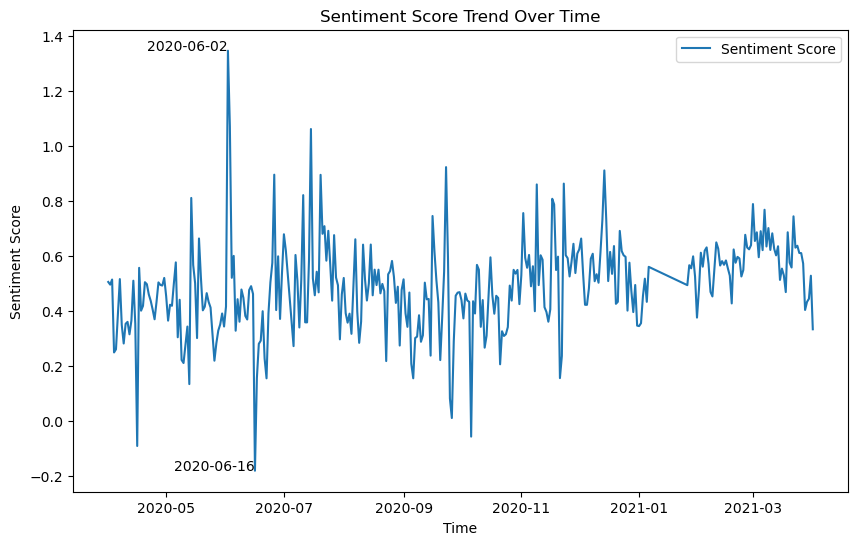

In [15]:
# Plot
plt.figure(figsize=(10,6))
plt.plot(daily_sentiment, label='Sentiment Score')

# Add labels to the outliers
for i in outliers.index:
    plt.text(i, outliers.loc[i], i.strftime('%Y-%m-%d'), horizontalalignment='right')

plt.title('Sentiment Score Trend Over Time')
plt.xlabel('Time')
plt.ylabel('Sentiment Score')
plt.legend()
plt.show()

## Find patterns and trends in the dataset.

>Include relevant vaccine related events for interpretation

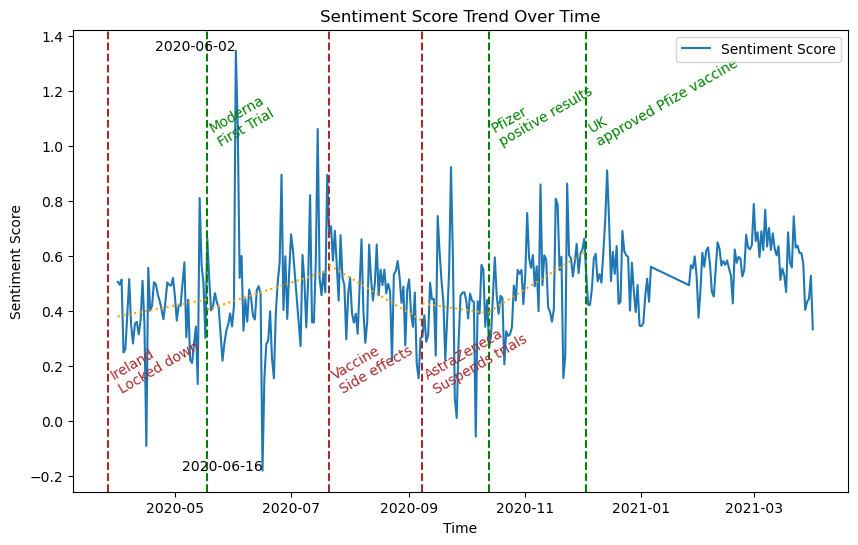

In [29]:
import numpy as np
# Dictionary for key events

events = {
    '2020-03-27': {'postive':0,'description': 'Ireland\nLocked down', 'url': "about:0"  },
    '2020-05-18': {'postive':1,'description': 'Moderna\nFirst Trial', 'url': "https://www.theguardian.com/society/2020/may/18/first-human-trial-results-raise-hopes-for-coronavirus-vaccine"  },
    '2020-07-21': {'postive':0,'description': 'Vaccine\nSide effects', 'url': 'https://www.wired.com/story/covid-19-vaccines-with-minor-side-effects-could-still-be-pretty-bad/'},    
    '2020-09-08': {'postive':0,'description': 'AstraZeneca\nSuspends trials', 'url': 'https://www.reuters.com/article/us-health-coronavirus-astrazeneca-idUSKBN25Z392'},    
    '2020-10-13': {'postive':1,'description': 'Pfizer\npositive results', 'url': 'https://www.pfizer.com/news/press-release/press-release-detail/pfizer-and-biontech-announce-positive-early-data-clinical'},
    '2020-12-03': {'postive':1,'description': 'UK\napproved Pfize vaccine', 'url': 'https://www.nature.com/articles/d41586-020-03441-8'},
}
events_df = pd.DataFrame.from_dict(events, orient='index')
events_df.index = pd.to_datetime(events_df.index)

# Plot
plt.figure(figsize=(10,6))
plt.plot(daily_sentiment, label='Sentiment Score')

# Add labels to the outliers
for i in outliers.index:
    plt.text(i, outliers.loc[i], i.strftime('%Y-%m-%d'), horizontalalignment='right')

# Add vertical lines for key events
for i in events_df.index:
    
    event_text = events_df.loc[i, 'description']
    event_positive = events_df.loc[i, 'postive']
    
    d = 1 if event_positive == 1 else 0.1;
    color = 'green' if event_positive == 1 else 'brown';
    
    
    plt.axvline(x=i, color=color, linestyle='--')
    plt.text(i, d, event_text, rotation=30, color=color, fontsize=10)
    
# Add vertical lines for key events and compute trend lines between the events
sorted_events = events_df.sort_index()
prev_date = None
for i in sorted_events.index:
    
    # If there is a previous date, calculate trend line and plot it
    if prev_date is not None:
        # Select sentiment data between two events
        sentiment_between = daily_sentiment[(daily_sentiment.index >= prev_date) & (daily_sentiment.index <= i)]
        # Calculate trend line
        z = np.polyfit(range(len(sentiment_between)), sentiment_between, 1)
        p = np.poly1d(z)
        plt.plot(sentiment_between.index, p(range(len(sentiment_between))), linestyle=':', color='orange')

    prev_date = i

plt.title('Sentiment Score Trend Over Time')
plt.xlabel('Time')
plt.ylabel('Sentiment Score')
plt.legend()
plt.show()
